In [ ]:
pip install tensorflow

In [80]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [81]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score
import html

In [82]:
depression = pd.read_csv("Mental-Health-Twitter.csv")
df = depression.copy()

X = df["post_text"]
y = df["label"]

In [83]:
df.sample(2)

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
5468,5468,626856395942576130,Thu Jul 30 20:46:25 +0000 2015,@thekatvond 👏🏻🙏🏻👌🏻💁🏻 so glad you don't eat ani...,49548465,677,1644,8375,12913,0,1
11825,11825,813203917911818240,Mon Dec 26 02:04:57 +0000 2016,@rolandsmartin I'm watching the Broncos vs Chi...,18831261,884,2389,8466,57269,0,0


In [84]:
df['length'] = df['post_text'].str.len()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,20000.0,9.999500e+03,5.773647e+03,0.000000e+00,4.999750e+03,9.999500e+03,1.499925e+04,1.999900e+04
post_id,20000.0,6.874728e+17,1.708396e+17,3.555966e+09,5.931686e+17,7.637400e+17,8.153124e+17,8.194574e+17
user_id,20000.0,3.548623e+16,1.606083e+17,1.472438e+07,3.242944e+08,1.052122e+09,2.285923e+09,7.631825e+17
followers,20000.0,9.004840e+02,1.899914e+03,0.000000e+00,1.770000e+02,4.760000e+02,1.197000e+03,2.861400e+04
friends,20000.0,7.824288e+02,1.834818e+03,0.000000e+00,2.110000e+02,5.610000e+02,7.010000e+02,2.851400e+04
favourites,20000.0,6.398236e+03,8.393073e+03,0.000000e+00,2.430000e+02,2.752000e+03,8.229000e+03,3.900800e+04
statuses,20000.0,4.439442e+04,1.407785e+05,3.000000e+00,5.129000e+03,1.325100e+04,5.289200e+04,1.063601e+06
retweets,20000.0,1.437927e+03,1.511967e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.395400e+05
label,20000.0,5.000000e-01,5.000125e-01,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,1.000000e+00
length,20000.0,8.246295e+01,3.828197e+01,4.000000e+00,5.000000e+01,7.700000e+01,1.180000e+02,1.690000e+02


In [85]:
df.sample(2)

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label,length
15598,15598,814689448730333184,Fri Dec 30 04:27:55 +0000 2016,@datukhensem hahahah. Dah fikir nak beli? Also...,490044008,1849,561,8229,86352,0,0,139
9593,9593,526938144328146945,Tue Oct 28 03:26:58 +0000 2014,Hearts beating outta my chest rn,1052121847,177,687,3066,8133,0,1,32


<Axes: xlabel='label', ylabel='count'>

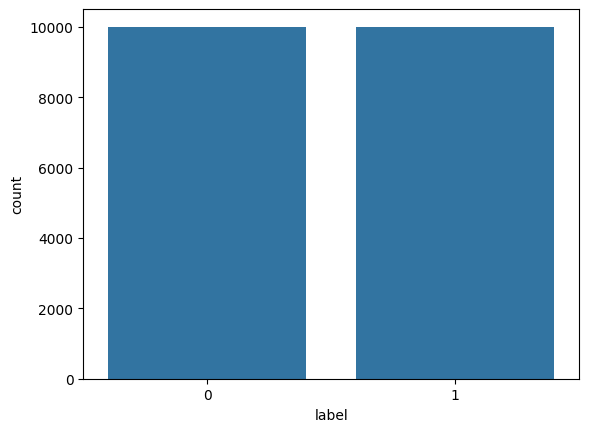

In [86]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='label', data=df)

In [87]:
df.isna().sum()

,0
Unnamed: 0,0
post_id,0
post_created,0
post_text,0
user_id,0
followers,0
friends,0
favourites,0
statuses,0
retweets,0


<Axes: >

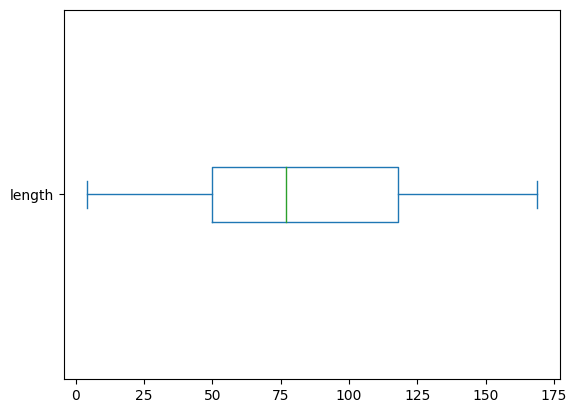

In [88]:
df['length'].plot(kind='box', vert=False)

In [89]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [91]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stopwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove RT symbol
    sentence = re.sub(r'^(RT|rt)[\s]+', '', sentence)

    # Remove username @ symbol
    sentence = re.sub(r'@\w+', '', sentence)

    # Remove the word 'user'
    sentence = re.sub(r'\buser\b', '', sentence)

    # Remove the word 'yong'
    sentence = re.sub(r'\byong\b', '', sentence)

    # Remove the word 'aleph'
    sentence = re.sub(r'\baleph\b', '', sentence)

    # Remove the word 'paytforluckysun'
    sentence = re.sub(r'\bpaytforluckysun\b', '', sentence)

    # Remove the word 'joe'
    sentence = re.sub(r'\bjoe\b', '', sentence)

    # Remove the word 'wearepayting'
    sentence = re.sub(r'\bwearepayting\b', '', sentence)

    # Remove the word 'foryong'
    sentence = re.sub(r'\bforyong\b', '', sentence)

    # Remove the word 'sos'
    sentence = re.sub(r'\bsos\b', '', sentence)

    # Remove the word 'mnwild'
    sentence = re.sub(r'\bmnwild\b', '', sentence)

    # Remove the word 'bbmas'
    sentence = re.sub(r'\bbbmas\b', '', sentence)

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove URLs/links
    sentence = re.sub(r"http\S+", "", sentence)

    # Replace html encoded characters
    sentence = html.unescape(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [92]:
df['preprocessed_text'] = df['post_text'].apply(preprocess_text)

In [93]:
# Convert labels to numpy array
y = np.array(y)

In [94]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['preprocessed_text'])

# Create a new column for the tokens
df['tokenized_text'] = df['preprocessed_text'].apply(lambda x: tokenizer.texts_to_sequences([x])[0])


In [95]:
df.sample(2)

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label,length,preprocessed_text,tokenized_text
10814,10814,813999010562375680,Wed Dec 28 06:44:22 +0000 2016,@cameronhoodkin ICONIC https://t.co/Q2XC0yHcer,3249600438,235,185,24407,22302,1,0,46,iconic,[2889]
1366,1366,580411189714399232,Tue Mar 24 16:49:45 +0000 2015,Huge thanks to @Official_NCFC for acknowledgin...,1629737760,2377,738,3189,5624,3,1,137,huge thanks acknowledging autismawarenessweek ...,"[1890, 55, 5032, 9800, 31, 6610, 72, 187, 1346]"


In [97]:
# Pad sequences to have same length
max_len = max(len(sequence) for sequence in df['tokenized_text'])
padded_sequences = pad_sequences(df['tokenized_text'], maxlen= max_len, padding='post')


In [98]:
padded_sequences.shape


(20000, 24)

In [99]:
padded_sequences [1]

array([1035,   16,  468, 2629,  991,  183,   15,  594,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-09-17 13:21:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-09-17 13:21:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-09-17 13:21:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [101]:
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [102]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip		 sample_data
glove.6B.200d.txt  glove.6B.50d.txt   Mental-Health-Twitter.csv
/content


In [103]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(tokenizer.word_index) + 1

vocab_length

19241

In [104]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()
print('Found %s word vectors.' % len(embeddings_dictionary))

Found 400000 word vectors.


In [105]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [106]:
embedding_matrix.shape

(19241, 100)

**LSTM**

In [107]:
from keras.layers import LSTM

In [108]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [109]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │       1,924,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,924,100 (7.34 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,924,100 (7.34 MB)

None


In [110]:
from keras.layers import Dense, Activation, Flatten

In [111]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - acc: 0.6139 - loss: 0.6421 - val_acc: 0.6737 - val_loss: 0.5847
Epoch 2/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - acc: 0.6716 - loss: 0.5806 - val_acc: 0.6803 - val_loss: 0.5613
Epoch 3/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - acc: 0.6908 - loss: 0.5508 - val_acc: 0.6909 - val_loss: 0.5376
Epoch 4/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - acc: 0.7128 - loss: 0.5159 - val_acc: 0.7034 - val_loss: 0.5434
Epoch 5/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - acc: 0.7168 - loss: 0.5188 - val_acc: 0.7116 - val_loss: 0.5457
Epoch 6/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - acc: 0.7451 - loss: 0.4865 - val_acc: 0.7172 - val_loss: 0.5333


In [112]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - acc: 0.7087 - loss: 0.5506


In [113]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5541234612464905
Test Accuracy: 0.703499972820282


In [114]:
from sklearn.metrics import confusion_matrix

# Predict probabilities for the test set
y_pred_prob = lstm_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)



125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Confusion Matrix:
[[1334  647]
 [ 539 1480]]


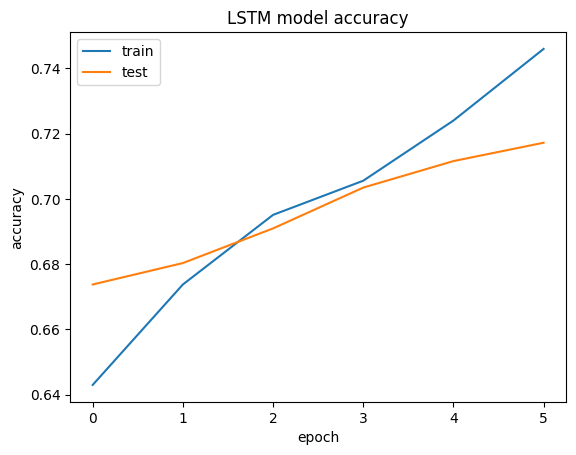

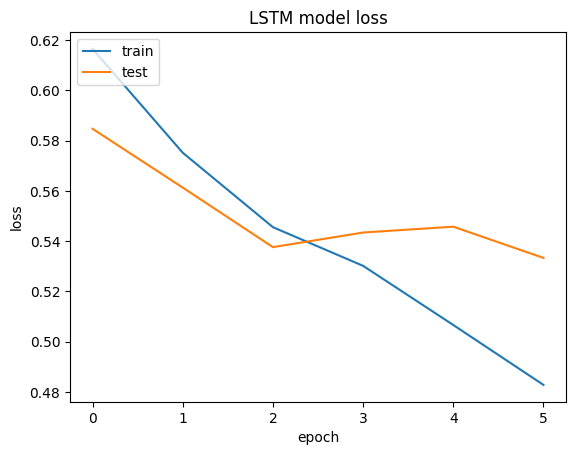

In [115]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Recurrent Neural Network

In [116]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, Flatten
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [117]:
# RNN Model
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
rnn_model.add(SimpleRNN(128, return_sequences=False))
rnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [118]:
# Model compiling
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [119]:
# Summary
print(rnn_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │       1,924,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,924,100 (7.34 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,924,100 (7.34 MB)

None


In [120]:
# Model training
rnn_model_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - acc: 0.5988 - loss: 0.6566 - val_acc: 0.6388 - val_loss: 0.6160
Epoch 2/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.6729 - loss: 0.5930 - val_acc: 0.6672 - val_loss: 0.5886
Epoch 3/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - acc: 0.6818 - loss: 0.5684 - val_acc: 0.6856 - val_loss: 0.5947
Epoch 4/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - acc: 0.6975 - loss: 0.5522 - val_acc: 0.6859 - val_loss: 0.5707
Epoch 5/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.7244 - loss: 0.5272 - val_acc: 0.6600 - val_loss: 0.5872
Epoch 6/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - acc: 0.7391 - loss: 0.5099 - val_acc: 0.6966 - val_loss: 0.5815


In [121]:
# Model Performance
score_rnn = rnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_rnn[0])
print("Test Accuracy:", score_rnn[1])

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.6850 - loss: 0.5859
Test Score: 0.5925894379615784
Test Accuracy: 0.6742500066757202


In [122]:
# Predict and Confusion Matrix
y_pred_prob_rnn = rnn_model.predict(X_test)
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
print("Confusion Matrix:")
print(cm_rnn)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Confusion Matrix:
[[1241  740]
 [ 563 1456]]


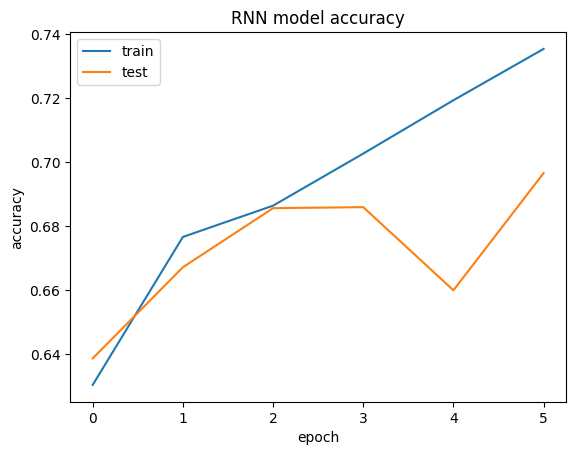

In [123]:
# Accuracy plot
plt.plot(rnn_model_history.history['acc'])
plt.plot(rnn_model_history.history['val_acc'])
plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

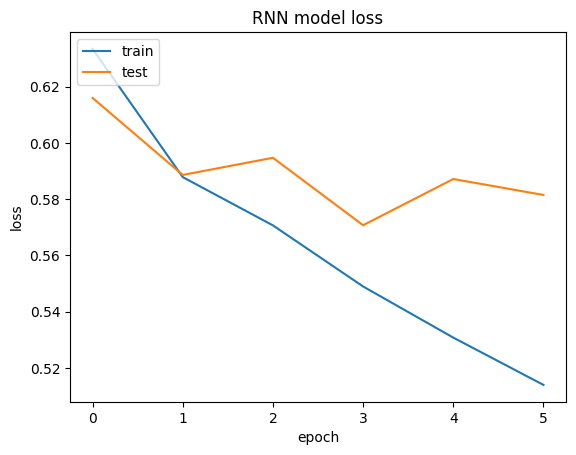

In [124]:
# Loss plot
plt.plot(rnn_model_history.history['loss'])
plt.plot(rnn_model_history.history['val_loss'])
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Gated Recurrent Unit (GRU)

In [125]:
from keras.layers import GRU

In [126]:
# GRU Model
gru_model = Sequential()
gru_model.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [127]:
# Model compiling
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [128]:
# Summary
print(gru_model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │       1,924,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,924,100 (7.34 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,924,100 (7.34 MB)

None


In [129]:
# Model training
gru_model_history = gru_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - acc: 0.5605 - loss: 0.6674 - val_acc: 0.6694 - val_loss: 0.5974
Epoch 2/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.6693 - loss: 0.5876 - val_acc: 0.6869 - val_loss: 0.5699
Epoch 3/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - acc: 0.6822 - loss: 0.5639 - val_acc: 0.6938 - val_loss: 0.5563
Epoch 4/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - acc: 0.6923 - loss: 0.5531 - val_acc: 0.7003 - val_loss: 0.5416
Epoch 5/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - acc: 0.7292 - loss: 0.5131 - val_acc: 0.7084 - val_loss: 0.5290
Epoch 6/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - acc: 0.7495 - loss: 0.4835 - val_acc: 0.6988 - val_loss: 0.5442


In [130]:
# Model Performance
score_gru = gru_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_gru[0])
print("Test Accuracy:", score_gru[1])

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.6858 - loss: 0.5609
Test Score: 0.5609528422355652
Test Accuracy: 0.6847500205039978


In [131]:
# Predict and Confusion Matrix
y_pred_prob_gru = gru_model.predict(X_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)
cm_gru = confusion_matrix(y_test, y_pred_gru)
print("Confusion Matrix:")
print(cm_gru)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Confusion Matrix:
[[1013  968]
 [ 293 1726]]


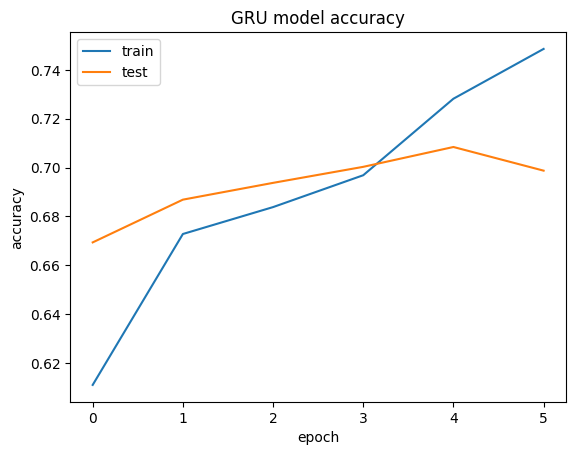

In [132]:
# Accuracy plot
plt.plot(gru_model_history.history['acc'])
plt.plot(gru_model_history.history['val_acc'])
plt.title('GRU model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

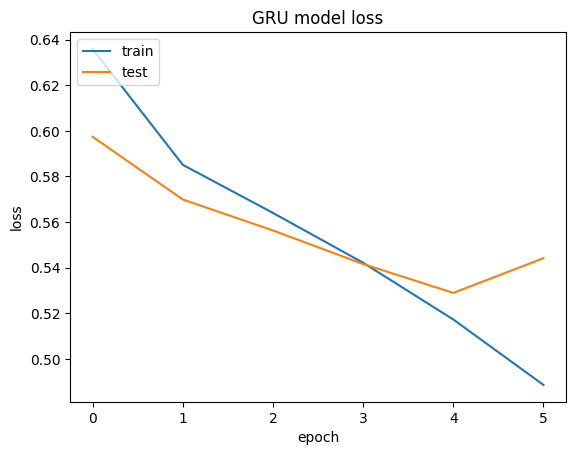

In [133]:
# Loss plot
plt.plot(gru_model_history.history['loss'])
plt.plot(gru_model_history.history['val_loss'])
plt.title('GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Transformer Based Model

In [134]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [135]:
# Input layer
input_layer = Input(shape=(max_len,))

In [136]:
# Embedding layer (for text data)
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [137]:
# MultiHeadAttention layer (query, key, value are the same)
attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(embedding_layer, embedding_layer)

In [138]:
# LayerNormalization
attention_output = LayerNormalization()(attention_output)

In [139]:
# Flatten the attention output
flatten_output = Flatten()(attention_output)

In [140]:
# Dropout for regularization
dropout_output = Dropout(0.1)(flatten_output)

In [141]:
# Output layer (binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout_output)

In [142]:
# Define the model
transformer_model = Model(inputs=input_layer, outputs=output_layer)

In [143]:
# Compile the model
transformer_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])

In [144]:
# Summary
print(transformer_model.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 24)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 24, 100)        │      1,924,100 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 24, 100)        │        206,436 │ embedding_8[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 100)        │            200 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 2400)           │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2400)           │              0 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │          2,401 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,133,137 (8.14 MB)

 Trainable params: 209,037 (816.55 KB)

 Non-trainable params: 1,924,100 (7.34 MB)

None


In [148]:
# Model training
transformer_model_history = transformer_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 361ms/step - acc: 0.7132 - loss: 0.5238 - val_acc: 0.7169 - val_loss: 0.5334
Epoch 2/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 309ms/step - acc: 0.7398 - loss: 0.4842 - val_acc: 0.7197 - val_loss: 0.5300
Epoch 3/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 289ms/step - acc: 0.7685 - loss: 0.4520 - val_acc: 0.7172 - val_loss: 0.5513
Epoch 4/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - acc: 0.7975 - loss: 0.4139 - val_acc: 0.7147 - val_loss: 0.5589
Epoch 5/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 303ms/step - acc: 0.8128 - loss: 0.3782 - val_acc: 0.7088 - val_loss: 0.5785
Epoch 6/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 413ms/step - acc: 0.8293 - loss: 0.3485 - val_acc: 0.7141 - val_loss: 0.6038


In [147]:
# Model evaluation
score_transformer = transformer_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score_transformer[0])
print("Test Accuracy:", score_transformer[1])

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - acc: 0.6737 - loss: 0.5772
Test Score: 0.5748119950294495
Test Accuracy: 0.6704999804496765


In [ ]:
# Make predictions on the test set
y_pred_prob_transformer = transformer_model.predict(X_test)

# Convert probabilities to binary class labels
y_pred_transformer = (y_pred_prob_transformer > 0.5).astype(int)

# Compute the confusion matrix
cm_transformer = confusion_matrix(y_test, y_pred_transformer)
print("Confusion Matrix:")
print(cm_transformer)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Confusion Matrix:
[[1273  708]
 [ 551 1468]]


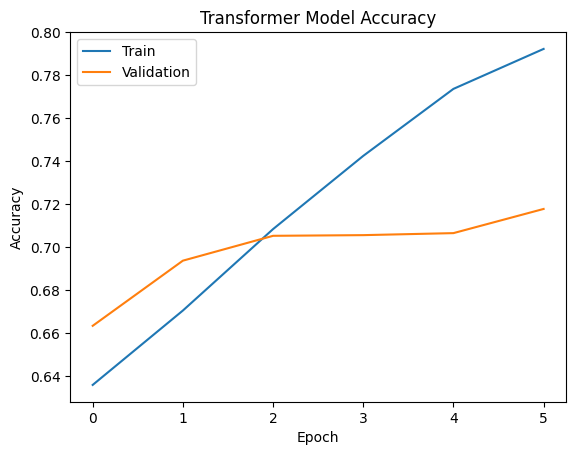

In [ ]:
# Accuracy Plot
plt.plot(transformer_model_history.history['acc'], label='train accuracy')
plt.plot(transformer_model_history.history['val_acc'], label='validation accuracy')
plt.title('Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

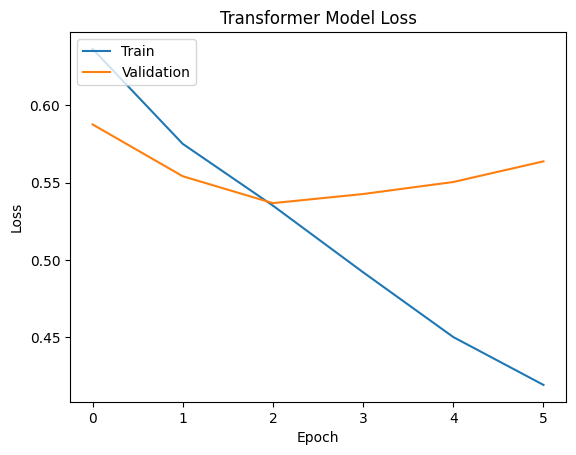

In [ ]:
# Loss Plot
plt.plot(transformer_model_history.history['loss'], label='train loss')
plt.plot(transformer_model_history.history['val_loss'], label='validation loss')
plt.title('Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Simple Neural Network

In [ ]:
# Neural Network architecture
from keras.layers import Dense, Activation, Flatten
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       1,924,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,924,100 (7.34 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,924,100 (7.34 MB)

None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.5888 - loss: 0.6659 - val_acc: 0.6356 - val_loss: 0.6261
Epoch 2/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6608 - loss: 0.6055 - val_acc: 0.6531 - val_loss: 0.6112
Epoch 3/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6838 - loss: 0.5862 - val_acc: 0.6634 - val_loss: 0.6046
Epoch 4/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6930 - loss: 0.5735 - val_acc: 0.6647 - val_loss: 0.6028
Epoch 5/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6951 - loss: 0.5712 - val_acc: 0.6619 - val_loss: 0.5996
Epoch 6/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6997 - loss: 0.5592 - val_acc: 0.6675 - val_loss: 0.6013


In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6614 - loss: 0.6020


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6026210784912109
Test Accuracy: 0.6582499742507935


In [ ]:

# Predict probabilities for the test set
y_pred_prob1 = snn_model.predict(X_test)

# Convert probabilities to class labels
y_pred1 = (y_pred_prob1 > 0.5).astype(int)

# Compute the confusion matrix
cm1 = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(cm1)



125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix:
[[1238  743]
 [ 624 1395]]


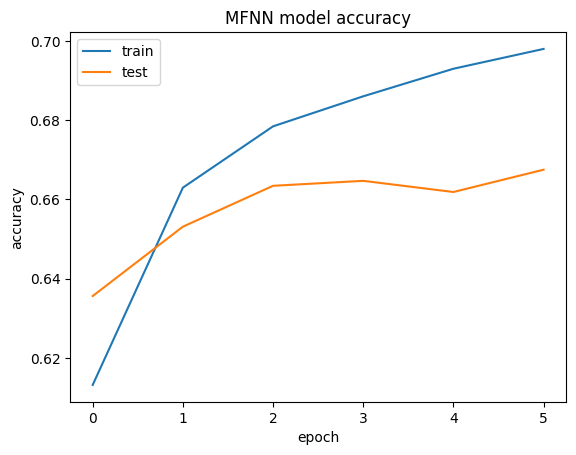

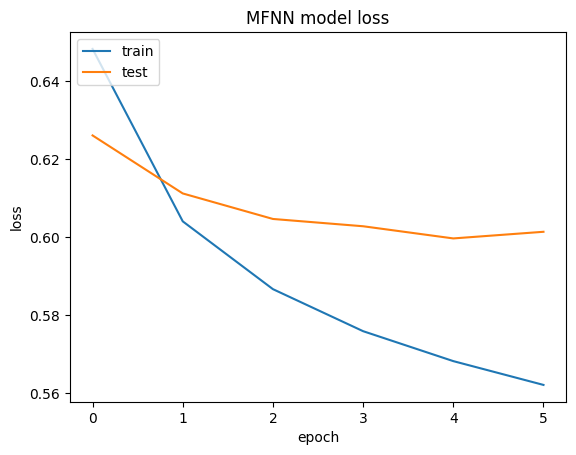

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('MFNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('MFNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Convolutional Neural Network


In [ ]:
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D

In [ ]:
# convolutional Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       1,924,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,924,100 (7.34 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,924,100 (7.34 MB)

None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - acc: 0.6203 - loss: 0.6394 - val_acc: 0.6706 - val_loss: 0.5870
Epoch 2/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc: 0.7329 - loss: 0.5317 - val_acc: 0.7078 - val_loss: 0.5518
Epoch 3/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - acc: 0.7734 - loss: 0.4765 - val_acc: 0.7069 - val_loss: 0.5426
Epoch 4/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - acc: 0.8196 - loss: 0.4245 - val_acc: 0.7103 - val_loss: 0.5458
Epoch 5/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.8527 - loss: 0.3748 - val_acc: 0.7153 - val_loss: 0.5367
Epoch 6/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - acc: 0.8843 - loss: 0.3250 - val_acc: 0.7125 - val_loss: 0.5426


In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.7087 - loss: 0.5586


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5594305396080017
Test Accuracy: 0.7039999961853027


In [ ]:
# Predict probabilities for the test set
y_pred_prob2 = cnn_model.predict(X_test)

# Convert probabilities to class labels
y_pred2 = (y_pred_prob2 > 0.5).astype(int)

# Compute the confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix:")
print(cm2)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
[[1271  710]
 [ 474 1545]]


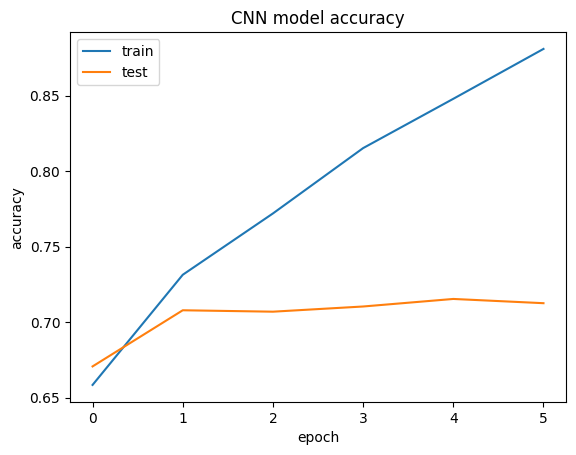

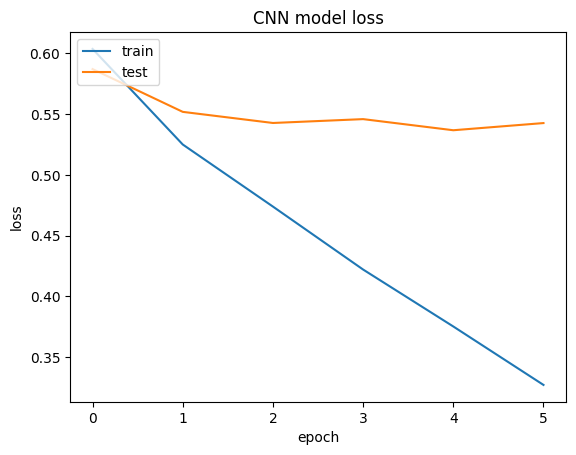

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

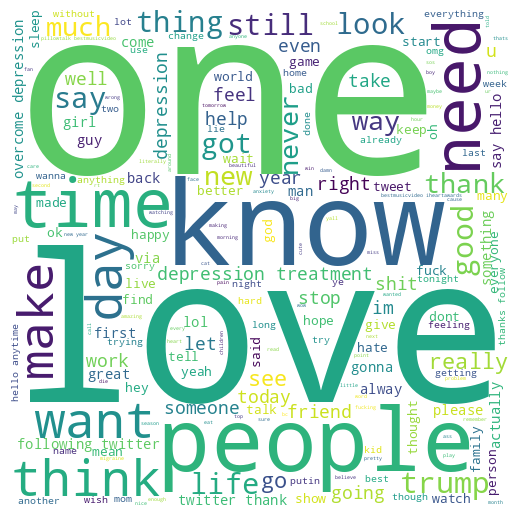

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all sentences in the preprocessed text data
all_text = ' '.join(posttext for posttext in df.preprocessed_text)

# Generate a word cloud object
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


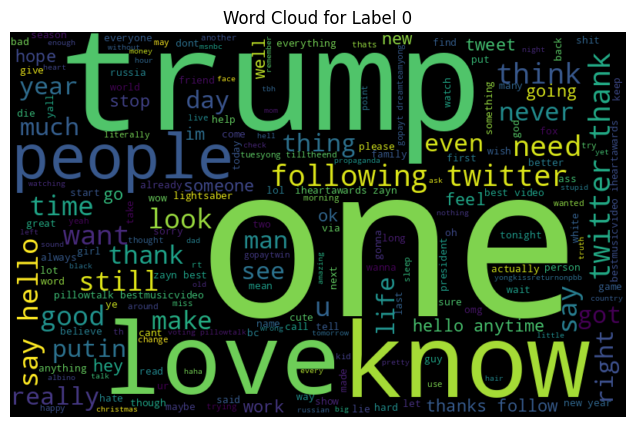

In [ ]:

# Get the text data and labels for label 0
X_label_0 = df[df['label'] == 0]['post_text'].values.tolist()

# Preprocess the text data
X_label_0 = [preprocess_text(text) for text in X_label_0]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=500, background_color="black").generate(" ".join(X_label_0))
plt.figure(figsize=(8, 5), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Label 0")
plt.show()


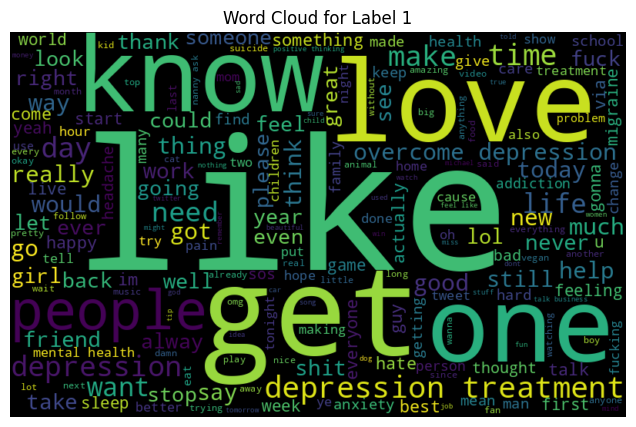

In [ ]:
# Get the text data and labels for label 1
X_label_1 = df[df['label'] == 1]['post_text'].values.tolist()

# Preprocess the text data
X_label_1 = [preprocess_text(text) for text in X_label_1]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=500, stopwords=stopwords.words('english'),background_color="black").generate(" ".join(X_label_1))
plt.figure(figsize=(8, 5), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Label 1")
plt.show()

In [ ]:
from collections import Counter

# Define the counter function
def count_words(text):
    tokens = text.split()
    return Counter(tokens)

# Apply the counter function to the preprocessed_text column
counters = df['preprocessed_text'].apply(count_words)

# Merge the counters into a single Counter object
merged_counters = Counter()
for c in counters:
    merged_counters.update(c)

freq_df = pd.DataFrame.from_dict(merged_counters, orient='index', columns=['frequency'])

# Sort the DataFrame by frequency in descending order
freq_df = freq_df.sort_values('frequency', ascending=False)

# Print the DataFrame
print(freq_df.head(10))

            frequency
like              992
depression        895
one               711
get               610
love              600
know              591
people            578
good              456
go                434
trump             425


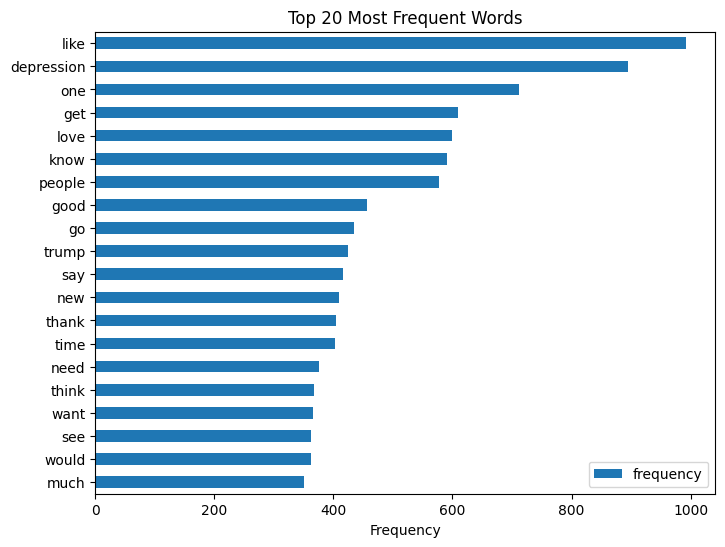

In [ ]:
# Generate a bar plot of the top 20 most frequent words
n = 20
fig, ax = plt.subplots(figsize=(8, 6))
freq_df[:n].sort_values('frequency', ascending=True).plot.barh(ax=ax)
ax.set_title(f'Top {n} Most Frequent Words')
ax.set_xlabel('Frequency')
plt.show()

In [ ]:
validation = pd.read_csv("depression_tweets (1).csv")
df_val = validation.copy()

In [ ]:
df_val.head()


,date,id,text,username,followers
0,2023-04-04 20:47:40+00:00,1643354671673745411,"Maybe adding excess sugar, allowing cancer cau...",clarichawrites,1690
1,2023-04-04 20:47:29+00:00,1643354627159605250,Ahhh yes my two weeks of manic depression is o...,chelseachavis,2719
2,2023-04-04 20:47:29+00:00,1643354625461063680,@TheLittleKittn @OldSchoolRS gets me out of de...,TheSonOfOdinTv,586
3,2023-04-04 20:47:27+00:00,1643354618104098817,@DreyfusJames I used that book to try to expla...,JonHartleyInBSE,1591
4,2023-04-04 20:47:24+00:00,1643354605105889280,Depression and anxiety is the new pandemic .\...,noahDoGood,1121


In [ ]:
df_val['length_val'] = df_val['text'].str.len()
df_val.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5000.0,1.643305e+18,2.810083e+13,1.643257e+18,1.643281e+18,1.643305e+18,1.643330e+18,1.643355e+18
followers,5000.0,1.086643e+04,2.630876e+05,0.000000e+00,8.000000e+01,3.040000e+02,1.168000e+03,1.354170e+07
length_val,5000.0,1.537010e+02,9.415756e+01,4.000000e+00,7.100000e+01,1.360000e+02,2.430000e+02,8.980000e+02


In [ ]:
df_val.isna().sum()

date          0
id            0
text          0
username      0
followers     0
length_val    0
dtype: int64

<Axes: >

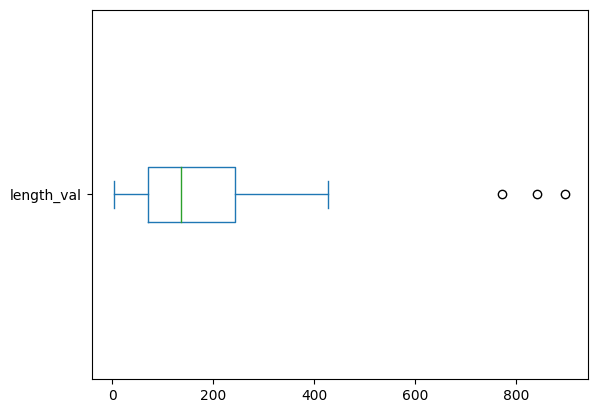

In [ ]:
df_val['length_val'].plot(kind='box', vert=False)

In [ ]:
df_val['preprocessed_text_val'] = df_val['text'].apply(preprocess_text)

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_val['preprocessed_text_val'])

# Create a new column for the tokens
df_val['tokenized_text_val'] = df_val['preprocessed_text_val'].apply(lambda x: tokenizer.texts_to_sequences([x])[0])


In [ ]:
df_val.sample(2)

,date,id,text,username,followers,length_val,preprocessed_text_val,tokenized_text_val
1921,2023-04-04 18:15:29+00:00,1643316373240840192,"Depression,\nIs the one who I never wanted in ...",squidl3gz,1,265,depression one never wanted first place want l...,"[2, 8, 30, 405, 76, 305, 28, 356, 8, 30, 298, ..."
672,2023-04-04 19:52:46+00:00,1643340856391344128,@Stephteff4200 @zorto_ @sneako dysphoria is an...,bulletcrow_,75,120,dysphoria emotional state caused distress typ...,"[376, 359, 280, 344, 1022, 3906, 3, 2]"


In [ ]:
# Pad sequences to have same length
#max_len = max(len(sequence) for sequence in df_val['tokenized_text_val'])
max_len=24
padded_sequences_val = pad_sequences(df_val['tokenized_text_val'], maxlen= max_len, padding='post')

In [ ]:
padded_sequences_val [1]

array([3535,  104,  196,  300,  613,    2, 5269,  215, 1424,   13,  672,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length_val = len(tokenizer.word_index) + 1

vocab_length_val

11907

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix_val = zeros((vocab_length_val, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector_val = embeddings_dictionary.get(word)
    if embedding_vector_val is not None:
        embedding_matrix_val[index] = embedding_vector_val

In [ ]:
embedding_matrix_val.shape

(11907, 100)

In [ ]:
y_pred_val = lstm_model.predict(padded_sequences_val)
y_pred_val_binary = np.round(y_pred_val)
y_pred_val_binary

157/157 [==============================] - 3s 14ms/step


array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:

y_pred_val_binary_df = pd.DataFrame(y_pred_val_binary, columns=['predicted_label'])


In [ ]:
y_pred_val_binary_df.value_counts()

predicted_label
1.0                2818
0.0                2182
dtype: int64

In [ ]:
df_val ['y_pred_lstm'] = y_pred_val_binary_df

In [ ]:
df_val.head(5)

,date,id,text,username,followers,length_val,preprocessed_text_val,tokenized_text_val,y_pred_lstm
0,2023-04-04 20:47:40+00:00,1643354671673745411,"Maybe adding excess sugar, allowing cancer cau...",clarichawrites,1690,191,maybe adding excess sugar allowing cancer caus...,"[124, 1423, 2752, 1148, 3534, 521, 497, 2235, ...",1.0
1,2023-04-04 20:47:29+00:00,1643354627159605250,Ahhh yes my two weeks of manic depression is o...,chelseachavis,2719,86,ahhh yes two weeks manic depression ahhhh oh y...,"[3535, 104, 196, 300, 613, 2, 5269, 215, 1424,...",0.0
2,2023-04-04 20:47:29+00:00,1643354625461063680,@TheLittleKittn @OldSchoolRS gets me out of de...,TheSonOfOdinTv,586,88,gets depression hardest times,"[301, 2, 1874, 186]",1.0
3,2023-04-04 20:47:27+00:00,1643354618104098817,@DreyfusJames I used that book to try to expla...,JonHartleyInBSE,1591,290,used book try explain depression manager shor...,"[112, 284, 140, 819, 2, 1617, 460, 435, 219, 7...",1.0
4,2023-04-04 20:47:24+00:00,1643354605105889280,Depression and anxiety is the new pandemic .\...,noahDoGood,1121,172,depression anxiety new pandemic psychiatrists ...,"[2, 3, 90, 581, 5271, 5272, 5273, 883, 378, 17...",1.0


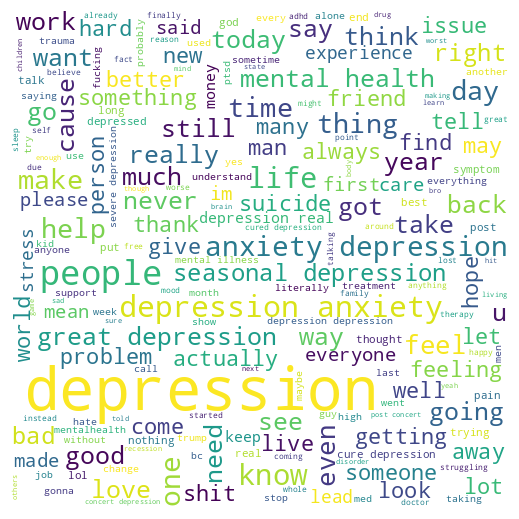

In [ ]:


# Join all sentences in the preprocessed text data
all_text1 = ' '.join(posttext for posttext in df_val.preprocessed_text_val)

# Generate a word cloud object
wordcloud1 = WordCloud(width=500, height=500, background_color='white').generate(all_text1)

# Display the word cloud
plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()